In [34]:
import csv
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
import string
import re
from sklearn.preprocessing import Normalizer
vectorizer = TfidfVectorizer()
tfidf_vect = TfidfVectorizer()
wn = nltk.WordNetLemmatizer()
string.punctuation
stop = stopwords.words('english')


In [154]:
# functions to read Amazon data into a pandas data frame
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# function to concatenate multiple Amazon datasets
def concatDF(data):
    df = pd.DataFrame()
    for dataset in data:
        dftemp = getDF(dataset)
        df = pd.concat([df, dftemp], axis=0)
    # drop unneeded columns
    df.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', \
                       'summary', 'unixReviewTime', 'reviewTime'], inplace= True)
    return df

def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stop]# To remove all stopwords
    return text

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

def lema(df,column):
    df['body_text_clean'] = df[column].apply(lambda x: remove_punct(x))
    df['body_text_tokenized'] = df['body_text_clean'].apply(lambda x: tokenize(x.lower()))
    df['body_text_nostop'] = df['body_text_tokenized'].apply(lambda x: remove_stopwords(x))
    df['body_text_lemmatized'] = df['body_text_nostop'].apply(lambda x: lemmatizing(x))
    it_list = []
    for row in df['body_text_lemmatized']:
        it_list.append(" ".join(row))
    df['joined_lemm'] = it_list
    final_df = pd.DataFrame()
    final_df['sentiment'] = df['sentiment']
    final_df['joined_lemm'] = df['joined_lemm']
    return final_df

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [8]:
read_csv = pd.read_csv('imdb_reviews_data.csv')

In [10]:
df = pd.DataFrame(read_csv)
df

,Unnamed: 0,text,sentiment
0,0,Story of a man who has unnatural feelings for ...,negative
1,1,Airport '77 starts as a brand new luxury 747 p...,negative
2,2,This film lacked something I couldn't put my f...,negative
3,3,"Sorry everyone,,, I know this is supposed to b...",negative
4,4,When I was little my parents took me along to ...,negative
...,...,...,...
49995,12495,I was extraordinarily impressed by this film. ...,positive
49996,12496,"Although I'm not a golf fan, I attended a snea...",positive
49997,12497,"From the start of ""The Edge Of Love"", the view...",positive
49998,12498,"This movie, with all its complexity and subtle...",positive


In [109]:
clean_df = lema(df,'text')
clean_df = clean_df.iloc[np.random.choice(np.arange(len(df)), 5000, False)]

In [110]:
clean_df['sentiments'] = df.sentiment.apply(lambda x: 1 if x in ['positive'] else 0)

In [116]:
x = clean_df['joined_lemm']
y = clean_df['sentiments']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
vectorized_train = vectorizer.transform(X_train).toarray()
vectorized_test = vectorizer.transform(X_test).toarray()
vectorized_val = vectorizer.transform(X_val).toarray()
norm = Normalizer().fit(vectorized_train)
norm_vectorized_train = norm.transform(vectorized_train)
norm_vectorized_test = norm.transform(vectorized_test)
norm_vectorized_val = norm.transform(vectorized_val)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test) 

In [156]:
export_vector = vectorizer.fit(X_train)

In [113]:
neg, pos = np.bincount(clean_df['sentiments'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5000
    Positive: 2497 (49.94% of total)



In [126]:
train_labels = np.array(y_train)
bool_train_labels = train_labels != 0
val_labels = np.array(y_val)
test_labels = np.array(y_test)

train_features = norm_vectorized_train
val_features = norm_vectorized_val
test_features = norm_vectorized_test

In [127]:

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4000,)
Validation labels shape: (200,)
Test labels shape: (800,)
Training features shape: (4000, 40745)
Validation features shape: (200, 40745)
Test features shape: (800, 40745)


In [128]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



In [129]:
EPOCHS = 50
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [130]:
model = make_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 16)                651936    
_________________________________________________________________
dense_51 (Dense)             (None, 50)                850       
_________________________________________________________________
dense_52 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 51        
Total params: 655,387
Trainable params: 655,387
Non-trainable params: 0
_________________________________________________________________


In [132]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8871


In [135]:
model = make_model()
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 4s 1s/step - loss: 0.8059 - tp: 51.0000 - fp: 5.0000 - tn: 2086.0000 - fn: 2058.0000 - accuracy: 0.5088 - precision: 0.9107 - recall: 0.0242 - auc: 0.5169 - prc: 0.5306 - val_loss: 0.7276 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 115.0000 - val_fn: 85.0000 - val_accuracy: 0.5750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.4250
Epoch 2/50
2/2 [==============================] - 0s 254ms/step - loss: 0.8018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1976.0000 - fn: 2024.0000 - accuracy: 0.4940 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5194 - prc: 0.5371 - val_loss: 0.7247 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 115.0000 - val_fn: 85.0000 - val_accuracy: 0.5750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6125 - val_prc: 0.4911
Epoch 3/50
2/2 [==============================] - 1s 287ms/step - loss: 0.7969 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1976.

Epoch 20/50
2/2 [==============================] - 0s 254ms/step - loss: 0.5699 - tp: 1571.0000 - fp: 280.0000 - tn: 1696.0000 - fn: 453.0000 - accuracy: 0.8167 - precision: 0.8487 - recall: 0.7762 - auc: 0.8954 - prc: 0.9079 - val_loss: 0.6317 - val_tp: 78.0000 - val_fp: 46.0000 - val_tn: 69.0000 - val_fn: 7.0000 - val_accuracy: 0.7350 - val_precision: 0.6290 - val_recall: 0.9176 - val_auc: 0.8486 - val_prc: 0.7881
Epoch 21/50
2/2 [==============================] - 0s 251ms/step - loss: 0.5562 - tp: 1678.0000 - fp: 329.0000 - tn: 1647.0000 - fn: 346.0000 - accuracy: 0.8313 - precision: 0.8361 - recall: 0.8291 - auc: 0.9064 - prc: 0.9119 - val_loss: 0.6243 - val_tp: 78.0000 - val_fp: 52.0000 - val_tn: 63.0000 - val_fn: 7.0000 - val_accuracy: 0.7050 - val_precision: 0.6000 - val_recall: 0.9176 - val_auc: 0.8645 - val_prc: 0.8135
Epoch 22/50
2/2 [==============================] - 1s 348ms/step - loss: 0.5305 - tp: 1742.0000 - fp: 293.0000 - tn: 1683.0000 - fn: 282.0000 - accuracy: 0.8562

Epoch 40/50
2/2 [==============================] - 0s 250ms/step - loss: 0.0951 - tp: 2021.0000 - fp: 3.0000 - tn: 1973.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.4224 - val_tp: 78.0000 - val_fp: 30.0000 - val_tn: 85.0000 - val_fn: 7.0000 - val_accuracy: 0.8150 - val_precision: 0.7222 - val_recall: 0.9176 - val_auc: 0.9151 - val_prc: 0.9058
Epoch 41/50
2/2 [==============================] - 1s 265ms/step - loss: 0.0830 - tp: 2021.0000 - fp: 2.0000 - tn: 1974.0000 - fn: 3.0000 - accuracy: 0.9987 - precision: 0.9990 - recall: 0.9985 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.4194 - val_tp: 78.0000 - val_fp: 31.0000 - val_tn: 84.0000 - val_fn: 7.0000 - val_accuracy: 0.8100 - val_precision: 0.7156 - val_recall: 0.9176 - val_auc: 0.9143 - val_prc: 0.9050
Epoch 42/50
2/2 [==============================] - 1s 323ms/step - loss: 0.0698 - tp: 2024.0000 - fp: 0.0000e+00 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - p

In [137]:
colors = ['red','blue']

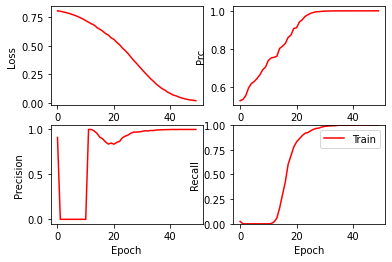

In [138]:
plot_metrics(baseline_history)

In [139]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4200577437877655
tp :  355.0
fp :  111.0
tn :  301.0
fn :  33.0
accuracy :  0.8199999928474426
precision :  0.7618025541305542
recall :  0.9149484634399414
auc :  0.9104944467544556
prc :  0.9023114442825317

Legitimate Transactions Detected (True Negatives):  301
Legitimate Transactions Incorrectly Detected (False Positives):  111
Fraudulent Transactions Missed (False Negatives):  33
Fraudulent Transactions Detected (True Positives):  355
Total Fraudulent Transactions:  388


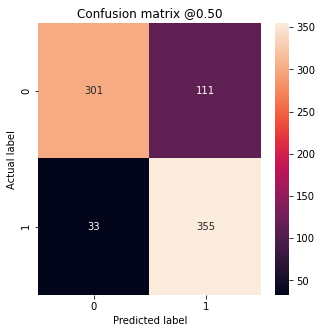

In [151]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

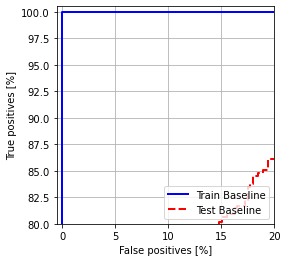

In [153]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[1])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [155]:
model.save("deep_sentiment_model_trained.h5")